In [11]:
# import the necessary packages
from PIL import ImageFont, ImageDraw, Image
from collections import namedtuple
from matplotlib import pyplot as plt
import pytesseract
import imutils
import cv2
import numpy as np
import pandas as pd
import re
import os
import math
import random
import time

# Utilities

In [12]:
from matplotlib import pyplot as plt
import re

'''display multiple images in Matplotlib subplots'''
def show_images(images, height=16, width=16, axis='on'):
    
    # define plot matrix layout
    n = len(images)
    if n == 0:
        return None
    elif n >= 4:
        nCols = 4
        nRows = math.ceil(n/4)
    else:
        nCols = n
        nRows = math.ceil(n/3)
        
    # create figure object
    fig = plt.figure(figsize=(height, width))
    
    # for each image
    for i, image in enumerate(images):
        # convert to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # add subplots to figure
        fig.add_subplot(nRows, nCols, i+1)
        plt.axis(axis)
        
        # add images to two subplots
        plt.imshow(image_rgb)
    
    # show entire plot
    plt.show()
    return None


'''display single image in popup window'''
def display_image(image, resizeRatio=1):
    (h, w) = image.shape[:2]
    cv2.namedWindow("output", cv2.WINDOW_NORMAL) 
    cv2.imshow("output", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


''' overlay a semi-transparent rectangle box atop an image '''
def drawTransparentRect(image, bbox, color=(0, 250, 0), alpha=0.5):
    # create two copies of the original image -- one for
    # the overlay and one for the final output image
    overlay = image.copy()
    output = image.copy()
    
    # draw a transparent rectangle using bbox
    cv2.rectangle(overlay, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, -1)
    
    # apply the overlay
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    
    return output


'''clean up OCR raw texts using regex'''
def cleanup(text):
    
    # remove ANSI escape chars
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    ansi_seq = re.compile(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]')
    text = ansi_escape.sub('', text)
    text = ansi_seq.sub('', text)
    
    # remove unwanted chars
    text = re.sub(r'[：:,。.ー|"\'“”.!()"/一=ー.—]', '', text)
    
    # remove consecutive and repetitive chars
    text = re.sub(r'[\,\\\ \+\-\*\&=]{2,}','',text)
    
    return text.strip()

# 1. Load Image

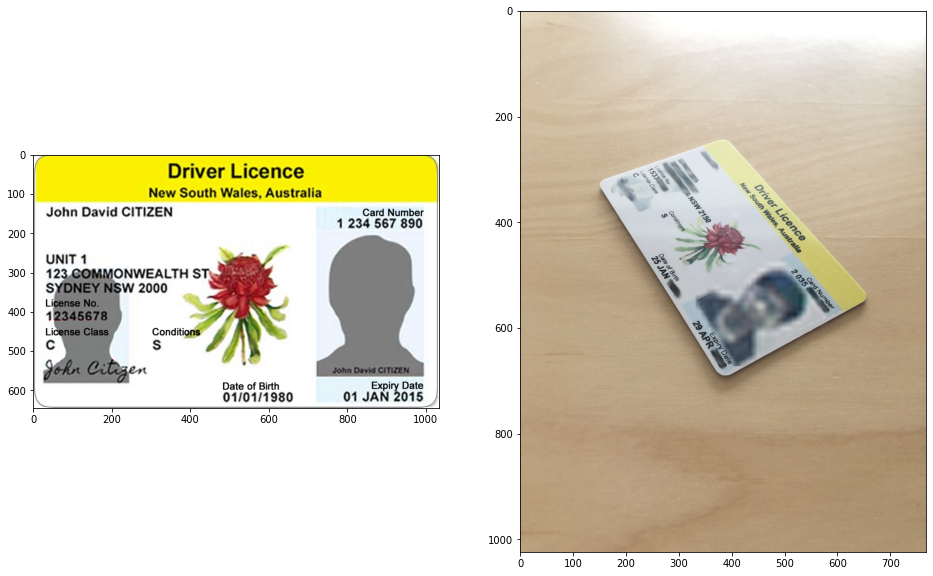

Resize ratio: 2.21x


In [13]:
RESIZE_WIDTH = 768

# Load our template image and query image 
templateImg = cv2.imread('images/nsw_dl_template.jpg')
queryImg = cv2.imread('images/test3.jpg')

# Resize to reduce computation time
if queryImg.shape[1] > RESIZE_WIDTH:
    ratio = queryImg.shape[1] / RESIZE_WIDTH
    queryResized = imutils.resize(queryImg, width = RESIZE_WIDTH)
else:
    queryResized = queryImg.copy()
    ratio = 1

# Get dimensions
templateH, templateW = templateImg.shape[:2]

# show loaded images
images = [templateImg, queryResized]
show_images(images)

print(f'Resize ratio: {ratio:.2f}x')

# 2. Feature matching

processing time: 0.435sec


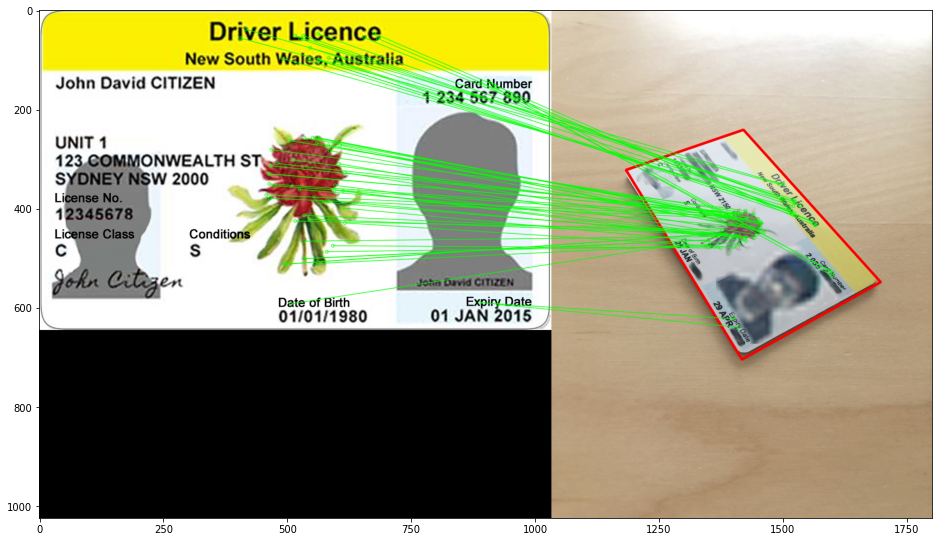

In [14]:
MIN_MATCH_COUNT = 20
FLANN_INDEX_KDTREE = 1

# initiate a SIFT feature detector
sift = cv2.SIFT_create()

t0 = time.time()

# find the keypoints and descriptors with SIFT using FLANN matcher
kp1, des1 = sift.detectAndCompute(templateImg, None)
kp2, des2 = sift.detectAndCompute(queryResized, None)

indexParams = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
searchParams = dict(checks = 50)

flann = cv2.FlannBasedMatcher(indexParams, searchParams)

matches = flann.knnMatch(des1, des2, k=2)

# store all good matches as per Lowe's ratio test
matched = []
for m,n in matches:
    if m.distance < 0.7 * n.distance:
        matched.append(m)

# when there's enough good matching points
if len(matched) > MIN_MATCH_COUNT:
    # extract matched template feature points
    srcPts = np.float32([ kp1[m.queryIdx].pt for m in matched ]).reshape(-1,1,2)
    
    # extract matched query image feature points
    dstPts = np.float32([ kp2[m.trainIdx].pt for m in matched ]).reshape(-1,1,2)
    
    # compute the transformation matrix (M) for homographically transforming the template to the query image 
    # using the matched SIFT feature points
    M, mask = cv2.findHomography(srcPts, dstPts, cv2.RANSAC, 5.0)
    
    # get a list of inliers (matched pointes)
    matchesMask = mask.ravel().tolist()
    
    # compute the corner vertices of the query image using the transformation matrix (M)
    templateCnr = np.float32([[0,0],[0,templateH-1],[templateW-1,templateH-1],[templateW-1,0]]).reshape(-1,1,2)
    queryCnr = cv2.perspectiveTransform(templateCnr, M)
    
    # draw a four-points polygon around the matched object, i.e. our ID card
    cv2.polylines(queryResized,[np.int32(queryCnr)],True,(0,0,250),3, cv2.LINE_AA)
    
else:
    print( "Not enough matches are found - {}/{}".format(len(matched), MIN_MATCH_COUNT) )
    matchesMask = None

t1 = time.time()

# draw visual masking for inlines on both images
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = None,
                   matchesMask = matchesMask,
                   flags = 2)
featureMatchImg = cv2.drawMatches(templateImg, kp1, queryResized, kp2, matched, None, **draw_params)

print(f'processing time: {t1-t0:.3f}sec')

images = [featureMatchImg]
show_images(images)

### 2. Perspective Warping

aspect ratio: 1.3968313490203432


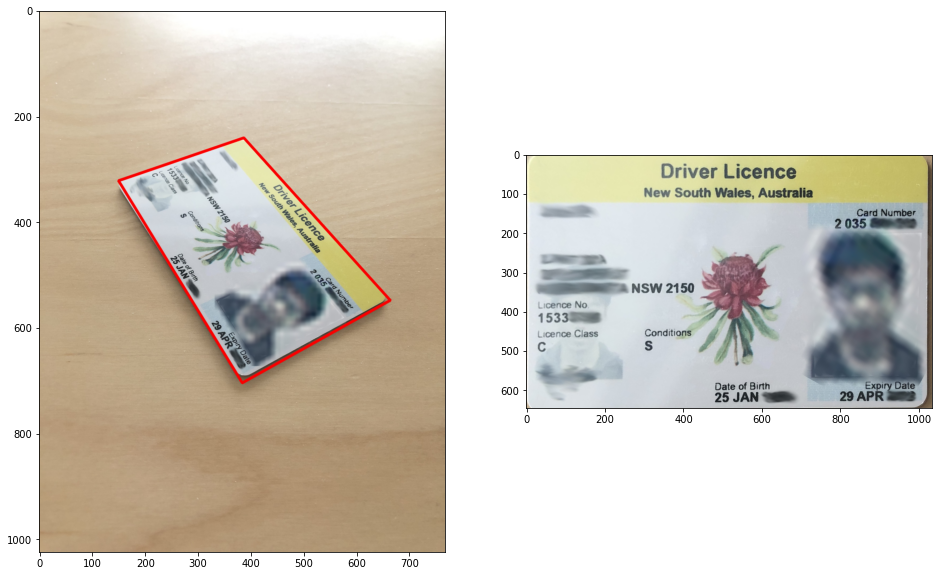

In [15]:
# extract vertices in the order of top-left, bottom-left, bottom-rright, top-right
(tl, bl, br, tr) = queryCnr

# compute the maximum length and width of our polygon (i.e. detected ID card) 
widthA = np.sqrt(((br[0][0] - bl[0][0]) ** 2) + ((br[0][1] - bl[0][1]) ** 2))
widthB = np.sqrt(((tr[0][0] - tl[0][0]) ** 2) + ((tr[0][1] - tl[0][1]) ** 2))
heightA = np.sqrt(((tr[0][0] - br[0][0]) ** 2) + ((tr[0][1] - br[0][1]) ** 2))
heightB = np.sqrt(((tl[0][0] - bl[0][0]) ** 2) + ((tl[0][1] - bl[0][1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
maxHeight = max(int(heightA), int(heightB))

# compute the ID card's asepct ratio
aspectRatio = maxWidth / (maxHeight + 0.01)
print(f'aspect ratio: {aspectRatio}')

# The aspect ratio of most ID cards should be close to the standard credit card's (= 1.586) if not distorted,
# although it may vary depending on the ID we use.
# if the aspect ratio of our polygon falls within an acceptable  range, give or take some margin of error
# considering the angle of the photo of the ID card.
if 1.3 <= aspectRatio <= 2.5:
    # define the birds-eye view vertices    
    dst = np.array([
        [0, 0],
        [0, templateH - 1],
        [templateW - 1, templateH - 1],
        [templateW - 1, 0]], dtype = "float32")

    # compute the perspective transform matrix (M), scale it back to the original size
    M = cv2.getPerspectiveTransform(queryCnr * ratio, dst)

    # use the transform matrix (M) to produce a top-down view of our ID card
    card = cv2.warpPerspective(queryImg, M, (templateW, templateH))

    # show results
    images = [queryResized, card]
    show_images(images)

In [16]:
# define the birds-eye view vertices    
dst = np.array([
    [0, 0],
    [0, templateH - 1],
    [templateW - 1, templateH - 1],
    [templateW - 1, 0]], dtype = "float32")

# compute the perspective transform matrix (M), scale it back to the original size
M = cv2.getPerspectiveTransform(queryCnr * ratio, dst)

# use the transform matrix (M) to produce a top-down view of our ID card
card = cv2.warpPerspective(queryImg, M, (templateW, templateH))

# 3. Define OCR Field Template

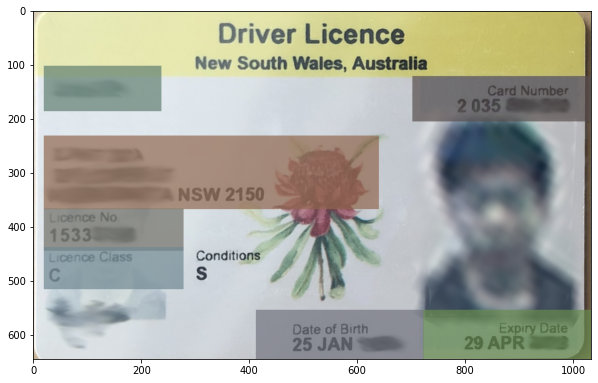

In [17]:
# create an OCR field template. Here we use the NSW D/L as an example
# the bbox field is defined as: startX, startY, Width and Height, all in expressed relative term.
OCRLocation = namedtuple("OCRLocation", ["id", "bbox", "filter_keywords"])

OCR_LOCATIONS = [
    OCRLocation("full_name", (.02, .16, .21, .13), []),
    OCRLocation("card_no", (.68, .19, .33, .13), ["Card Number"]),
    OCRLocation("address", (.02, .36, .6, .21), []),
    OCRLocation("license_no", (.02, .57, .25, .12), ["Licence No"]),
    OCRLocation("license_class", (.02, .68, .25, .12), ["Licence Class"]),
    OCRLocation("dob", (.4, .86, .3, .14), ["Date of Birth"]),
    OCRLocation("expiry", (.7, .86, .3, .14), ["Expiry Date"])
]

# draw the OCR template on our perspective corrected ID card
ocrFields = card.copy()
for loc in OCR_LOCATIONS:
    (x, y, w, h) = loc.bbox
    startX = int(x * card.shape[1])
    startY = int(y * card.shape[0])
    endX = int(w * card.shape[1]) + startX
    endY = int(h * card.shape[0]) + startY
    
    # draw OCR template bbox
    (b,g,r) = [random.randint(75,150) for i in range(3)]
    ocrFields = drawTransparentRect(ocrFields, (startX, startY, endX, endY), (b, g, r), 0.7)

images = [ocrFields]
show_images(images, height=10, width=10)

# 4. OCR using Tesseract

In [18]:
# setting OCR tesseract parameters
lang = 'eng'
oem = '1'
psm = '1'
custom_config = r"-l {} --oem {} --psm {}".format(lang, oem, psm)

print(f'Current OCR setting: {custom_config}')

Current OCR setting: -l eng --oem 1 --psm 1


[INFO] OCR ID document


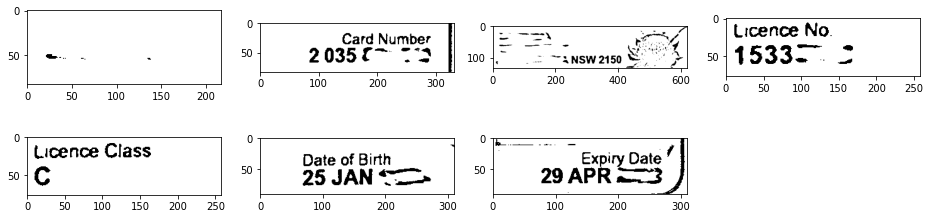

In [19]:
print("[INFO] OCR ID document")

results = []
images = []

# gray scale
gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)

for loc in OCR_LOCATIONS:
    (x, y, w, h) = loc.bbox
    startX = int(x * card.shape[1])
    startY = int(y * card.shape[0])
    endX = int(w * card.shape[1]) + startX
    endY = int(h * card.shape[0]) + startY
    
    # kernel preprocessing
    field = gray[startY:endY, startX:endX]
    field = cv2.adaptiveThreshold(field,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,17)
    field = cv2.fastNlMeansDenoising(field,None,7,11,11)
    kernel = np.ones((1,1),np.uint8)
    field = cv2.morphologyEx(field, cv2.MORPH_CLOSE, kernel)
    images.append(field)
    
    # OCR with Tesseract
    text = pytesseract.image_to_string(field, config=custom_config)
    
    # remove filter keywords and do basic text clean up
    for word in loc.filter_keywords:
        text = re.sub(word, '', text)
    
    text = ' '.join(text.splitlines())
    text = cleanup(text)
    
    results.append({"Field": loc.id, "Value": text})
    
show_images(images, 16, 4)

In [20]:
# display OCR results as a dataframe
pd.set_option('display.max_colwidth', None)
pd.DataFrame(results) 

,Field,Value
0,full_name,
1,card_no,20350 722
2,address,o wv 2 ~N0 z
3,license_no,153327 2
4,license_class,tucence ClassCc
5,dob,25 JAN <T
6,expiry,baR 729 APRT3
